In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, flatten
from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, Module, Dropout, ReLU
import torch.nn.functional as F
import random
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ])

trainset = datasets.MNIST('./', download=True, train=True,  transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)
print(trainset.data.size())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
print(len(trainloader))

torch.Size([60000, 28, 28])
469


In [8]:
class CNN(nn.Module):
    def __init__(self, l1,l2,l3):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(1,16, kernel_size=3,stride=1,padding=1)
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(16,32, kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(32*7*7,l1)
        self.fc2 = nn.Linear(l1,l2)
        self.fc3 = nn.Linear(l2,l3)
        self.fc4 = nn.Linear(l3,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x) 
        #print(x.shape[2:])
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        #x = F.log_softmax(self.fc3(x), dim=1)       
        return x

In [7]:
#test model
net=CNN(50,50,25)
x=torch.randn(64,1,28,28)
print(net(x).shape)

torch.Size([64, 10])


In [34]:
params = sum([p.numel() for p in net.parameters()])
params

87335

In [56]:
#list of different values for each hidden layer
#l1 = number of units to be hidden layer fc1
#l3 = number of units to be hidden layer fc3
#l3 = number of units to be hidden layer fc3
l1 = [10,20,30,50,100,150,250,350,500,600,800,1000,1024]
l2 = [5,10,35,50,100,128,150,150,200,250,300,400,512]
l3 = [5,20,20,25,50,64,70,100,128,150,200,300,512]

In [57]:
def train(model, loss_fn, optimizer, epoch):
    model.to(device)
    step = 0
    params = sum([p.numel() for p in model.parameters()])
    for e in range(epoch):
        train_loss = 0
        trainacc=0
        for images, labels in trainloader:
            step+=1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model(images) #forward propagation
            loss = loss_fn(logps, labels) #calculate loss
            train_loss+=loss.item()
            
            _, pred = logps.max(1)
            trainacc += (pred == labels).sum()
            
            loss.backward() #backward propagation
            optimizer.step() #update weights
            
        tloss = train_loss/len(trainloader)
        trainaccr = trainacc/len(trainset)
        with torch.no_grad():
            valloss = 0
            acc = 0
            model.eval()
            for img, label in testloader:
                img, label = img.to(device), label.to(device)
                logps = model(img) #forward propagation
                loss = loss_fn(logps, label) #calculate loss
                valloss+=loss.item()
                _, pred = logps.max(1)
                acc += (pred == label).sum()
            vloss = valloss/len(testloader)
            vaccr = acc/len(testset)

            #if e%10==0:
            #print("Epoch: {}  Train Loss: {:.4f}  Val Loss: {:.4f}  Val_Acc: {:.2}".format(e, tloss, vloss, vaccr))
            
        model.train()
            
    #print(tloss, trainaccr.item(), vloss, vaccr.item())
    return tloss, trainaccr.item(), vloss, vaccr.item(), params

In [58]:
loss_fn = nn.NLLLoss()
epoch = 5
trainloss_list = []
trainacc_list = []
testloss_list = []
testacc_list = []
parameters = []
for i in range(len(l1)):
    print(f'\n=============Model{str(i)}=============')
    model = CNN(l1[i],l2[i],l3[i])
    #print(model)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    tloss, trainaccr, vloss, vaccr, params = train(model, loss_fn, optimizer, epoch)
    trainloss_list.append(tloss)
    trainacc_list.append(trainaccr)
    testloss_list.append(vloss)
    testacc_list.append(vaccr)
    parameters.append(params)


=============Model0=============

=============Model1=============

=============Model2=============

=============Model3=============

=============Model4=============

=============Model5=============

=============Model6=============

=============Model7=============

=============Model8=============

=============Model9=============

=============Model10=============

=============Model11=============

=============Model12=============


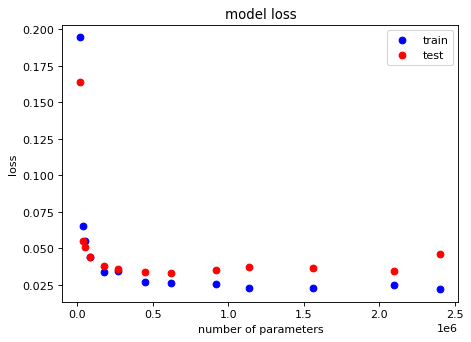

In [59]:
fig = plt.figure(figsize=(6, 8), dpi=80)
plt.subplot(2,1,2)
#plt.plot(np.arange(0,epoch), cnnloss, "b")
plt.scatter(parameters, trainloss_list, c="b")
plt.scatter(parameters, testloss_list, c="r")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('number of parameters')
plt.legend(['train', 'test'])
plt.tight_layout()

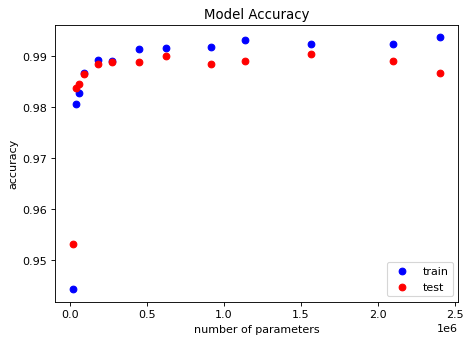

In [60]:
fig = plt.figure(figsize=(6, 8), dpi=80)
plt.subplot(2,1,2)
#plt.plot(np.arange(0,epoch), cnnloss, "b")
plt.scatter(parameters, trainacc_list, c="b")
plt.scatter(parameters, testacc_list, c="r")
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('number of parameters')
plt.legend(['train', 'test'])
plt.tight_layout()